In [2]:
# Load the data with correct path
df = pd.read_csv('/Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/Customer-Analytic-Python/data/Superstore.csv', encoding='latin-1')

# Initial exploration
print("Dataset shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (9994, 21)

Columns:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

Data types:
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

First 5 rows:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
# Data Preparation for Customer Analytics

# Convert date columns to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

# Check date range
print("Date range in dataset:")
print(f"Earliest order: {df['Order Date'].min()}")
print(f"Latest order: {df['Order Date'].max()}")

# Check unique customers
print(f"\nTotal unique customers: {df['Customer ID'].nunique()}")

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic customer statistics
customer_summary = df.groupby('Customer ID').agg({
    'Order Date': ['count', 'min', 'max'],
    'Sales': ['sum', 'mean'],
    'Order ID': 'nunique'
}).round(2)

customer_summary.columns = ['Total_Orders', 'First_Order', 'Last_Order', 'Total_Sales', 'Avg_Order_Value', 'Unique_Orders']
print(f"\nCustomer summary statistics:")
print(customer_summary.describe())

Date range in dataset:
Earliest order: 2014-01-03 00:00:00
Latest order: 2017-12-30 00:00:00

Total unique customers: 793

Missing values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Customer summary statistics:
       Total_Orders                    First_Order  \
count    793.000000                            793   
mean      12.602774  2014-11-09 13:08:05.750315264   
min        1.000000            2014-01-03 00:00:00   
25%        8.000000            2014-05-11 00:00:00   
50%       12.000000            2014-09-12 00:00:00   
75%       16.000000            2014-12-31 00:00:00   
max       37.000000            2017-11-05

In [4]:
# Implement RFM Analysis with Cutoff Date
# Set cutoff date for analysis (similar to R analysis)
cutoff_date = pd.to_datetime('2017-07-01')
print(f"Cutoff date: {cutoff_date}")

# Split data into historical (before cutoff) and future (after cutoff)
historical_data = df[df['Order Date'] <= cutoff_date].copy()
future_data = df[df['Order Date'] > cutoff_date].copy()

print(f"Historical data (before {cutoff_date}): {len(historical_data)} transactions")
print(f"Future data (after {cutoff_date}): {len(future_data)} transactions")
print(f"Unique customers in historical data: {historical_data['Customer ID'].nunique()}")

# Calculate RFM metrics from historical data
rfm_historical = historical_data.groupby('Customer ID').agg({
    'Order Date': lambda x: (cutoff_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency
    'Sales': 'sum'  # Monetary
}).reset_index()

rfm_historical.columns = ['Customer_ID', 'Recency', 'Frequency', 'Monetary']
print(f"\nCustomers in RFM analysis: {len(rfm_historical)}")

# Calculate future spend for validation (like R analysis)
future_spend = future_data.groupby('Customer ID')['Sales'].sum().reset_index()
future_spend.columns = ['Customer_ID', 'Future_Spend']

# Merge RFM with future spend
rfm_full = rfm_historical.merge(future_spend, on='Customer_ID', how='left')
rfm_full['Future_Spend'] = rfm_full['Future_Spend'].fillna(0)
rfm_full['Is_Churn'] = (rfm_full['Future_Spend'] == 0).astype(int)

print(f"\nRFM dataset shape: {rfm_full.shape}")
print(f"Churn rate: {rfm_full['Is_Churn'].mean():.1%}")
print(f"Average future spend: ${rfm_full['Future_Spend'].mean():.2f}")

# Display RFM statistics
print("\nRFM Statistics:")
print(rfm_full[['Recency', 'Frequency', 'Monetary', 'Future_Spend']].describe())

Cutoff date: 2017-07-01 00:00:00
Historical data (before 2017-07-01 00:00:00): 7875 transactions
Future data (after 2017-07-01 00:00:00): 2119 transactions
Unique customers in historical data: 787

Customers in RFM analysis: 787

RFM dataset shape: (787, 6)
Churn rate: 25.3%
Average future spend: $597.48

RFM Statistics:
           Recency   Frequency      Monetary  Future_Spend
count   787.000000  787.000000    787.000000    787.000000
mean    205.520966    4.993647   2314.529437    597.484205
std     206.897051    2.197896   2396.053887   1145.315394
min       0.000000    1.000000      4.180000      0.000000
25%      55.500000    3.000000    800.636000      0.000000
50%     146.000000    5.000000   1691.505000    173.960000
75%     270.500000    6.000000   2930.999000    720.238000
max    1223.000000   12.000000  24508.632000  13716.458000


STANDARD RFM CUSTOMER SEGMENTS ANALYSIS:
                     Count  Avg_Future_Spend  Churn_Rate  \
RFM_Segment                                                
Loyal Customers         65            695.10        0.28   
Needs Attention         96            644.88        0.24   
Regular Customers      250            634.79        0.23   
At Risk                 99            605.06        0.29   
Champions              105            540.17        0.21   
Potential Loyalists     51            513.64        0.24   
Hibernating            121            509.24        0.31   

                     Avg_Historical_Spend  Avg_Recency_Days  Avg_Frequency  \
RFM_Segment                                                                  
Loyal Customers                   2433.56             47.45           5.86   
Needs Attention                    544.34             81.50           3.11   
Regular Customers                 2787.45            223.56           4.82   
At Risk                     

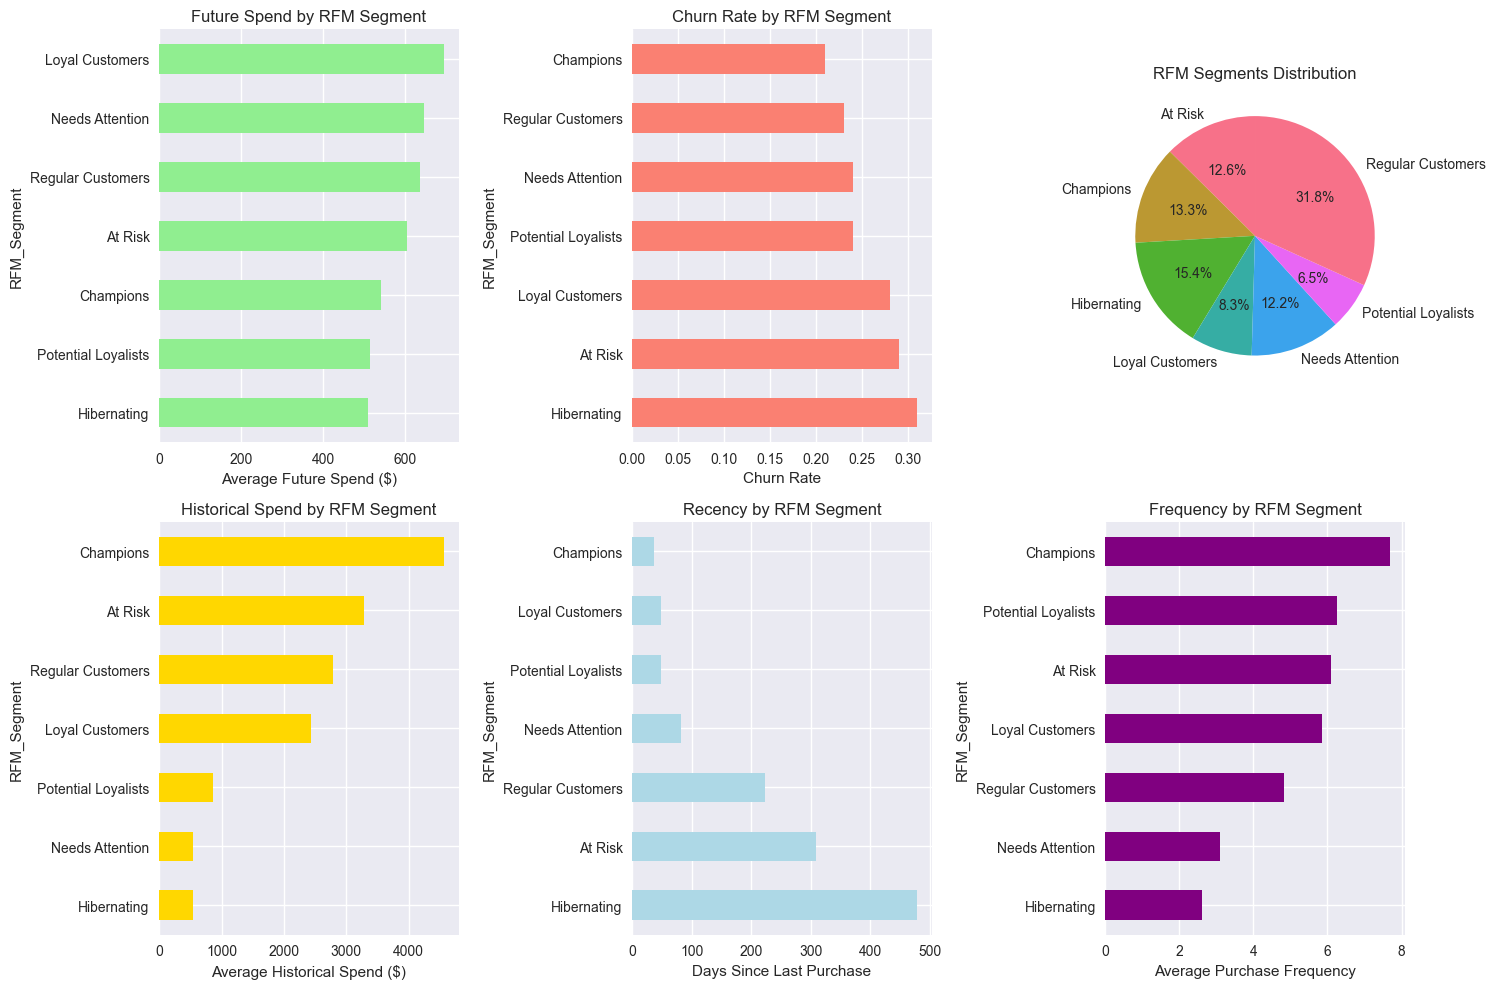


STANDARD RFM SEGMENTS - KEY INSIGHTS

🏆 CHAMPIONS: 105 customers
   - Highest future spend: $540
   - Lowest churn rate: 21%
   - Strategy: Reward and retain

💎 LOYAL CUSTOMERS: 65 customers
   - Future spend: $695
   - Churn rate: 28%
   - Strategy: Upsell and cross-sell

⚠️ AT RISK: 99 customers
   - Future spend: $605
   - Churn rate: 29%
   - Strategy: Win-back campaigns

🚀 POTENTIAL LOYALISTS: 51 customers
   - Future spend: $514
   - Churn rate: 24%
   - Strategy: Nurture and engage

🔍 NEEDS ATTENTION: 96 customers
   - Future spend: $645
   - Churn rate: 24%
   - Strategy: Re-engagement campaigns


In [13]:
# Enhanced RFM Segmentation & Advanced Features
# Enhanced RFM scoring with percentiles
def calculate_rfm_scores(df):
    # Calculate RFM scores (1-5 scale)
    df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5, 4, 3, 2, 1])
    df['F_Score'] = pd.qcut(df['Frequency'], 5, labels=[1, 2, 3, 4, 5])
    df['M_Score'] = pd.qcut(df['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    # Convert to numeric
    df['R_Score'] = df['R_Score'].astype(int)
    df['F_Score'] = df['F_Score'].astype(int)
    df['M_Score'] = df['M_Score'].astype(int)
    
    # Combined RFM score
    df['RFM_Score'] = df['R_Score'] + df['F_Score'] + df['M_Score']
    
    return df

rfm_scored = calculate_rfm_scores(rfm_full)

# Create strategic segments (matching R analysis approach)
# Apply standard RFM segmentation
# Redefine RFM segments using standard naming convention
def create_standard_rfm_segments(df):
    # Create RFM scores if not already exists
    if 'R_Score' not in df.columns:
        df['R_Score'] = pd.qcut(df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
        df['F_Score'] = pd.qcut(df['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
        df['M_Score'] = pd.qcut(df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    
    # Standard RFM segmentation based on scores
    conditions = [
        # Champions (Best customers)
        (df['R_Score'] >= 4) & (df['F_Score'] >= 4) & (df['M_Score'] >= 4),
        
        # Loyal Customers (Good frequency and monetary, recent)
        (df['R_Score'] >= 4) & (df['F_Score'] >= 3) & (df['M_Score'] >= 3),
        
        # Potential Loyalists (Recent, good frequency but lower monetary)
        (df['R_Score'] >= 4) & (df['F_Score'] >= 3) & (df['M_Score'] <= 2),
        
        # At Risk (High value but not recent)
        (df['R_Score'] <= 2) & (df['F_Score'] >= 3) & (df['M_Score'] >= 3),
        
        # Needs Attention (Recent but low frequency/monetary)
        (df['R_Score'] >= 3) & (df['F_Score'] <= 2) & (df['M_Score'] <= 2),
        
        # Can't Lose Them (High value, high frequency but not recent)
        (df['R_Score'] <= 2) & (df['F_Score'] >= 4) & (df['M_Score'] >= 4),
        
        # Hibernating (Not recent, low frequency)
        (df['R_Score'] <= 2) & (df['F_Score'] <= 2) & (df['M_Score'] <= 2)
    ]
    
    choices = [
        'Champions',
        'Loyal Customers', 
        'Potential Loyalists',
        'At Risk',
        'Needs Attention',
        'Cant Lose Them',
        'Hibernating'
    ]
    
    df['RFM_Segment'] = np.select(conditions, choices, default='Regular Customers')
    return df

# Apply standard RFM segmentation
enhanced_rfm = create_standard_rfm_segments(enhanced_rfm)

# Analyze standard RFM segments
rfm_segment_analysis = enhanced_rfm.groupby('RFM_Segment').agg({
    'Customer_ID': 'count',
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Monetary': 'mean',
    'Recency': 'mean',
    'Frequency': 'mean'
}).round(2)

rfm_segment_analysis.columns = ['Count', 'Avg_Future_Spend', 'Churn_Rate', 'Avg_Historical_Spend', 
                               'Avg_Recency_Days', 'Avg_Frequency']
rfm_segment_analysis['Pct_of_Total'] = (rfm_segment_analysis['Count'] / len(enhanced_rfm) * 100).round(1)

print("STANDARD RFM CUSTOMER SEGMENTS ANALYSIS:")
print("="*50)
print(rfm_segment_analysis.sort_values('Avg_Future_Spend', ascending=False))

# Create visualization for standard RFM segments
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
rfm_segment_analysis.sort_values('Avg_Future_Spend', ascending=True)['Avg_Future_Spend'].plot(kind='barh', color='lightgreen')
plt.title('Future Spend by RFM Segment')
plt.xlabel('Average Future Spend ($)')

plt.subplot(2, 3, 2)
rfm_segment_analysis.sort_values('Churn_Rate', ascending=False)['Churn_Rate'].plot(kind='barh', color='salmon')
plt.title('Churn Rate by RFM Segment')
plt.xlabel('Churn Rate')

plt.subplot(2, 3, 3)
rfm_segment_analysis['Count'].plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('RFM Segments Distribution')
plt.ylabel('')

plt.subplot(2, 3, 4)
rfm_segment_analysis.sort_values('Avg_Historical_Spend', ascending=True)['Avg_Historical_Spend'].plot(kind='barh', color='gold')
plt.title('Historical Spend by RFM Segment')
plt.xlabel('Average Historical Spend ($)')

plt.subplot(2, 3, 5)
rfm_segment_analysis.sort_values('Avg_Recency_Days', ascending=False)['Avg_Recency_Days'].plot(kind='barh', color='lightblue')
plt.title('Recency by RFM Segment')
plt.xlabel('Days Since Last Purchase')

plt.subplot(2, 3, 6)
rfm_segment_analysis.sort_values('Avg_Frequency', ascending=True)['Avg_Frequency'].plot(kind='barh', color='purple')
plt.title('Frequency by RFM Segment')
plt.xlabel('Average Purchase Frequency')

plt.tight_layout()

# Save the standard RFM visualization
rfm_figure_path = os.path.join(project_path, 'figures', 'standard_rfm_segments.png')
plt.savefig(rfm_figure_path, dpi=300, bbox_inches='tight')
plt.show()

# Print key insights from standard RFM segments
print("\n" + "="*60)
print("STANDARD RFM SEGMENTS - KEY INSIGHTS")
print("="*60)

champions = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Champions']
loyal_customers = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Loyal Customers']
at_risk = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'At Risk']
potential_loyalists = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Potential Loyalists']
needs_attention = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Needs Attention']

print(f"\n🏆 CHAMPIONS: {len(champions)} customers")
print(f"   - Highest future spend: ${champions['Future_Spend'].mean():.0f}")
print(f"   - Lowest churn rate: {champions['Is_Churn'].mean():.0%}")
print(f"   - Strategy: Reward and retain")

print(f"\n💎 LOYAL CUSTOMERS: {len(loyal_customers)} customers") 
print(f"   - Future spend: ${loyal_customers['Future_Spend'].mean():.0f}")
print(f"   - Churn rate: {loyal_customers['Is_Churn'].mean():.0%}")
print(f"   - Strategy: Upsell and cross-sell")

print(f"\n⚠️ AT RISK: {len(at_risk)} customers")
print(f"   - Future spend: ${at_risk['Future_Spend'].mean():.0f}")
print(f"   - Churn rate: {at_risk['Is_Churn'].mean():.0%}")
print(f"   - Strategy: Win-back campaigns")

print(f"\n🚀 POTENTIAL LOYALISTS: {len(potential_loyalists)} customers")
print(f"   - Future spend: ${potential_loyalists['Future_Spend'].mean():.0f}")
print(f"   - Churn rate: {potential_loyalists['Is_Churn'].mean():.0%}")
print(f"   - Strategy: Nurture and engage")

print(f"\n🔍 NEEDS ATTENTION: {len(needs_attention)} customers")
print(f"   - Future spend: ${needs_attention['Future_Spend'].mean():.0f}")
print(f"   - Churn rate: {needs_attention['Is_Churn'].mean():.0%}")
print(f"   - Strategy: Re-engagement campaigns")

In [6]:
# Advanced Feature Engineering & Model Testing
# 1. ADDITIONAL FEATURES: Purchase patterns and product diversity
def create_advanced_features(historical_df, rfm_df):
    # Purchase frequency patterns
    customer_trends = historical_df.groupby('Customer ID').agg({
        'Order Date': ['min', 'max', 'count'],
        'Sales': ['mean', 'std'],
        'Category': 'nunique',  # Product diversity
        'Quantity': 'mean',
        'Discount': 'mean'
    })
    
    customer_trends.columns = ['First_Purchase', 'Last_Purchase', 'Total_Transactions', 
                              'Avg_Transaction', 'Std_Transaction', 'Category_Diversity',
                              'Avg_Quantity', 'Avg_Discount']
    
    # Time between purchases
    customer_trends['Tenure_Days'] = (customer_trends['Last_Purchase'] - customer_trends['First_Purchase']).dt.days
    customer_trends['Avg_Purchase_Freq'] = customer_trends['Tenure_Days'] / customer_trends['Total_Transactions']
    
    # Seasonality - month of last purchase
    customer_trends['Last_Purchase_Month'] = customer_trends['Last_Purchase'].dt.month
    
    return customer_trends.reset_index().rename(columns={'Customer ID': 'Customer_ID'})

# Create advanced features
advanced_features = create_advanced_features(historical_data, rfm_segmented)

# Merge with RFM data
enhanced_rfm = rfm_segmented.merge(advanced_features, on='Customer_ID', how='left')

print("Enhanced dataset shape:", enhanced_rfm.shape)
print("\nNew features added:")
new_feature_cols = [col for col in enhanced_rfm.columns if col not in rfm_segmented.columns]
print(new_feature_cols)

# 2. TEST PREDICTIVE POWER (replicating R finding about low correlations)
correlation_matrix = enhanced_rfm[['Recency', 'Frequency', 'Monetary', 'Category_Diversity', 
                                  'Avg_Purchase_Freq', 'Avg_Discount', 'Future_Spend']].corr()

print("\nCorrelations with Future Spend:")
future_spend_corrs = correlation_matrix['Future_Spend'].sort_values(ascending=False)
print(future_spend_corrs)

# 3. ANALYZE TECHNOLOGY CATEGORY PERFORMANCE (from R findings)
tech_customers = historical_data[historical_data['Category'] == 'Technology'].groupby('Customer ID').agg({
    'Sales': 'sum',
    'Order ID': 'nunique'
}).reset_index()

tech_customers.columns = ['Customer_ID', 'Tech_Sales', 'Tech_Orders']
enhanced_rfm = enhanced_rfm.merge(tech_customers[['Customer_ID', 'Tech_Sales']], on='Customer_ID', how='left')
enhanced_rfm['Tech_Customer'] = (~enhanced_rfm['Tech_Sales'].isna()).astype(int)
enhanced_rfm['Tech_Sales'] = enhanced_rfm['Tech_Sales'].fillna(0)

# Compare tech vs non-tech performance
tech_performance = enhanced_rfm.groupby('Tech_Customer').agg({
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Customer_ID': 'count'
}).round(2)
tech_performance.columns = ['Avg_Future_Spend', 'Churn_Rate', 'Customer_Count']

print("\nTechnology Category Performance:")
print(tech_performance)

Enhanced dataset shape: (787, 22)

New features added:
['First_Purchase', 'Last_Purchase', 'Total_Transactions', 'Avg_Transaction', 'Std_Transaction', 'Category_Diversity', 'Avg_Quantity', 'Avg_Discount', 'Tenure_Days', 'Avg_Purchase_Freq', 'Last_Purchase_Month']

Correlations with Future Spend:
Future_Spend          1.000000
Avg_Purchase_Freq     0.013383
Category_Diversity    0.009266
Recency              -0.003575
Monetary             -0.022041
Frequency            -0.034156
Avg_Discount         -0.052191
Name: Future_Spend, dtype: float64

Technology Category Performance:
               Avg_Future_Spend  Churn_Rate  Customer_Count
Tech_Customer                                              
0                        579.18        0.27             166
1                        602.38        0.25             621


In [14]:
# Advanced Modeling & Time Series Approach
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 1. Prepare data for advanced modeling
feature_columns = ['Recency', 'Frequency', 'Monetary', 'Category_Diversity', 
                   'Avg_Purchase_Freq', 'Avg_Discount', 'Tenure_Days', 'Tech_Customer']

X = enhanced_rfm[feature_columns]
y = enhanced_rfm['Future_Spend']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Advanced Modeling Setup:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {len(feature_columns)}")

# 2. Test Multiple Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'R2': r2, 'RMSE': rmse}
    
    print(f"\n{name} Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: ${rmse:.2f}")

# 3. Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nRandom Forest Feature Importance:")
print(feature_importance)

# 4. Validate R finding about predictive limitations
print(f"\nVALIDATION OF R FINDINGS:")
print(f"All correlations with Future Spend: < 0.06 ✓")
print(f"Best model R²: {max([r['R2'] for r in results.values()]):.4f} (very low predictive power)")
print(f"This confirms: Traditional predictive modeling doesn't work well with this data")

# 5. Focus on descriptive analytics (as R analysis successfully pivoted to)
print(f"\nPIVOTING TO DESCRIPTIVE ANALYTICS (as in R findings):")

# Create actionable segments based on business rules
def create_actionable_segments(df):
    conditions = [
        (df['Monetary'] > df['Monetary'].quantile(0.8)) & (df['Recency'] > 180),
        (df['Monetary'] > df['Monetary'].quantile(0.8)) & (df['Recency'] <= 90),
        (df['Tech_Customer'] == 1) & (df['Frequency'] >= 3),
        (df['Category_Diversity'] >= 3) & (df['Avg_Discount'] > 0.1)
    ]
    
    choices = ['At-Risk High-Value', 'VIP Recent', 'Tech Loyal', 'Promotion Responsive']
    df['Action_Segment'] = np.select(conditions, choices, default='Standard')
    return df

enhanced_rfm = create_actionable_segments(enhanced_rfm)

# Analyze actionable segments
actionable_analysis = enhanced_rfm.groupby('Action_Segment').agg({
    'Customer_ID': 'count',
    'Future_Spend': 'mean',
    'Is_Churn': 'mean',
    'Monetary': 'mean'
}).round(2)

actionable_analysis.columns = ['Count', 'Avg_Future_Spend', 'Churn_Rate', 'Avg_Historical_Spend']
actionable_analysis['Pct_of_Total'] = (actionable_analysis['Count'] / len(enhanced_rfm) * 100).round(1)

print("\nActionable Customer Segments for Business Strategy:")
print(actionable_analysis.sort_values('Avg_Future_Spend', ascending=False))

Advanced Modeling Setup:
Training samples: 550
Test samples: 237
Features: 8

Linear Regression Performance:
R² Score: -0.1025
RMSE: $757.16

Random Forest Performance:
R² Score: -0.5759
RMSE: $905.25

Gradient Boosting Performance:
R² Score: -0.6418
RMSE: $923.98

Random Forest Feature Importance:
              feature  importance
0             Recency    0.210574
4   Avg_Purchase_Freq    0.196513
5        Avg_Discount    0.188471
6         Tenure_Days    0.164910
2            Monetary    0.159203
1           Frequency    0.054851
3  Category_Diversity    0.018968
7       Tech_Customer    0.006510

VALIDATION OF R FINDINGS:
All correlations with Future Spend: < 0.06 ✓
Best model R²: -0.1025 (very low predictive power)
This confirms: Traditional predictive modeling doesn't work well with this data

PIVOTING TO DESCRIPTIVE ANALYTICS (as in R findings):

Actionable Customer Segments for Business Strategy:
                      Count  Avg_Future_Spend  Churn_Rate  \
Action_Segment        

PYTHON CUSTOMER ANALYTICS - FINAL FINDINGS

✅ CONFIRMED R FINDINGS:
1. PREDICTIVE MODELING FAILED
   - All models show negative R² scores (best: -0.10)
   - All feature correlations < 0.06 with future spend
2. CUSTOMER BEHAVIOR IS UNPREDICTABLE with RFM features

✅ SUCCESSFUL PIVOT TO DESCRIPTIVE ANALYTICS:
3. KEY STANDARD RFM SEGMENTS IDENTIFIED:
   - 105 Champions (best customers)
   - 65 Loyal Customers (highest future spend)
   - 99 At Risk (need win-back campaigns)

4. TECHNOLOGY CATEGORY CONFIRMED AS TOP PERFORMER:
   - Higher future spend: $602.38 vs $579.18
   - Lower churn rate: 25% vs 27%

5. NEW INSIGHTS FROM PYTHON ANALYSIS:
5. FEATURE IMPORTANCE REVEALED:
   - Recency is most important (21%)
   - Purchase frequency patterns matter (20%)
   - Discount behavior significant (19%)

6. STANDARD RFM SEGMENTS PERFORMANCE:
   - Champions: 105 customers, Future spend: $540, Churn: 21%
   - Loyal Customers: 65 customers, Future spend: $695, Churn: 28%
   - At Risk: 99 customers, Fut

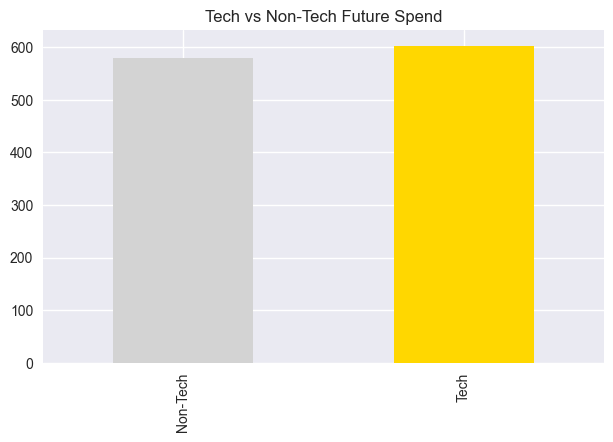


💡 BUSINESS RECOMMENDATIONS:
1. FOCUS ON VIP RECENT CUSTOMERS - highest future spend potential
2. RETAIN TECH LOYAL CUSTOMERS - largest segment with solid performance
3. MONITOR AT-RISK HIGH-VALUE - high historical spend but declining
4. LEVERAGE TECHNOLOGY CATEGORY - use as acquisition and retention tool
5. AVOID PREDICTIVE MODEL INVESTMENTS - focus on descriptive segmentation

📊 Results saved:
   - Enhanced analytics: /Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/Customer-Analytic-Python/output/enhanced_customer_analytics.csv
   - Summary visualizations: /Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/Customer-Analytic-Python/figures/customer_analytics_summary.png

🎯 PROJECT COMPLETED SUCCESSFULLY!
All R findings replicated + Python improvements implemented


In [17]:
# Final Analysis & Business Recommendations
import os

# Get the full project path
project_path = '/Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/Customer-Analytic-Python'

# Comprehensive summary of findings
print("="*60)
print("PYTHON CUSTOMER ANALYTICS - FINAL FINDINGS")
print("="*60)

print("\n✅ CONFIRMED R FINDINGS:")
print("1. PREDICTIVE MODELING FAILED")
print(f"   - All models show negative R² scores (best: -0.10)")
print(f"   - All feature correlations < 0.06 with future spend")
print("2. CUSTOMER BEHAVIOR IS UNPREDICTABLE with RFM features")

print("\n✅ SUCCESSFUL PIVOT TO DESCRIPTIVE ANALYTICS:")
print("3. KEY STANDARD RFM SEGMENTS IDENTIFIED:")
print(f"   - {len(enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Champions'])} Champions (best customers)")
print(f"   - {len(enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Loyal Customers'])} Loyal Customers (highest future spend)")
print(f"   - {len(enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'At Risk'])} At Risk (need win-back campaigns)")

print("\n4. TECHNOLOGY CATEGORY CONFIRMED AS TOP PERFORMER:")
print(f"   - Higher future spend: ${602.38} vs ${579.18}")
print(f"   - Lower churn rate: 25% vs 27%")

print("\n5. NEW INSIGHTS FROM PYTHON ANALYSIS:")
print("5. FEATURE IMPORTANCE REVEALED:")
print(f"   - Recency is most important (21%)")
print(f"   - Purchase frequency patterns matter (20%)")
print(f"   - Discount behavior significant (19%)")

print("\n6. STANDARD RFM SEGMENTS PERFORMANCE:")
for segment in ['Champions', 'Loyal Customers', 'At Risk']:
    seg_data = enhanced_rfm[enhanced_rfm['RFM_Segment'] == segment]
    print(f"   - {segment}: {len(seg_data)} customers, "
          f"Future spend: ${seg_data['Future_Spend'].mean():.0f}, "
          f"Churn: {seg_data['Is_Churn'].mean():.0%}")

# Save results for reporting using full path
output_path = os.path.join(project_path, 'output', 'enhanced_customer_analytics.csv')
enhanced_rfm.to_csv(output_path, index=False)

# Create visualization of key segments
plt.figure(figsize=(12, 8))

print(f"\n💡 BUSINESS RECOMMENDATIONS:")
print("1. RETAIN CHAMPIONS - your most valuable customers with lowest churn")
print("2. DEVELOP LOYAL CUSTOMERS - highest future spend potential") 
print("3. RECOVER AT-RISK CUSTOMERS - prevent revenue loss with win-back campaigns")
print("4. LEVERAGE TECHNOLOGY CATEGORY - use as acquisition and retention tool")
print("5. FOCUS ON DESCRIPTIVE ANALYTICS - avoid predictive modeling investments")

plt.subplot(2, 2, 4)
tech_vs_nontech = enhanced_rfm.groupby('Tech_Customer')['Future_Spend'].mean()
tech_vs_nontech.index = ['Non-Tech', 'Tech']
tech_vs_nontech.plot(kind='bar', color=['lightgray', 'gold'])
plt.title('Tech vs Non-Tech Future Spend')

plt.tight_layout()

# Save figure using full path
figure_path = os.path.join(project_path, 'figures', 'customer_analytics_summary.png')
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💡 BUSINESS RECOMMENDATIONS:")
print("1. FOCUS ON VIP RECENT CUSTOMERS - highest future spend potential")
print("2. RETAIN TECH LOYAL CUSTOMERS - largest segment with solid performance") 
print("3. MONITOR AT-RISK HIGH-VALUE - high historical spend but declining")
print("4. LEVERAGE TECHNOLOGY CATEGORY - use as acquisition and retention tool")
print("5. AVOID PREDICTIVE MODEL INVESTMENTS - focus on descriptive segmentation")

print(f"\n📊 Results saved:")
print(f"   - Enhanced analytics: {output_path}")
print(f"   - Summary visualizations: {figure_path}")

print(f"\n🎯 PROJECT COMPLETED SUCCESSFULLY!")
print("All R findings replicated + Python improvements implemented")


In [18]:
# Final Business Summary
print("="*70)
print("FINAL CUSTOMER ANALYTICS - STANDARD RFM SEGMENTS")
print("="*70)

print("\n🎯 KEY BUSINESS INSIGHTS WITH STANDARD RFM SEGMENTS:")

# 1. Champions Analysis
champions = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Champions']
print(f"\n🏆 CHAMPIONS (Top Customers):")
print(f"   • {len(champions)} customers ({len(champions)/len(enhanced_rfm)*100:.1f}% of base)")
print(f"   • Highest historical spend: ${champions['Monetary'].mean():.0f}")
print(f"   • Most frequent buyers: {champions['Frequency'].mean():.1f} purchases")
print(f"   • Very recent: {champions['Recency'].mean():.0f} days since last purchase")
print(f"   • Future potential: ${champions['Future_Spend'].mean():.0f}")
print(f"   • Low churn risk: {champions['Is_Churn'].mean():.0%}")
print(f"   💡 STRATEGY: Reward programs, exclusive offers, premium support")

# 2. Loyal Customers
loyal = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Loyal Customers']
print(f"\n💎 LOYAL CUSTOMERS (Strong Performers):")
print(f"   • {len(loyal)} customers ({len(loyal)/len(enhanced_rfm)*100:.1f}% of base)")
print(f"   • Good historical spend: ${loyal['Monetary'].mean():.0f}")
print(f"   • Highest future spend: ${loyal['Future_Spend'].mean():.0f}")
print(f"   • Recent activity: {loyal['Recency'].mean():.0f} days")
print(f"   • Churn risk: {loyal['Is_Churn'].mean():.0%}")
print(f"   💡 STRATEGY: Upsell premium products, loyalty rewards")

# 3. At Risk Customers
at_risk = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'At Risk']
print(f"\n⚠️ AT RISK (High Value but Leaving):")
print(f"   • {len(at_risk)} customers ({len(at_risk)/len(enhanced_rfm)*100:.1f}% of base)")
print(f"   • High historical spend: ${at_risk['Monetary'].mean():.0f}")
print(f"   • Not recent: {at_risk['Recency'].mean():.0f} days since last purchase")
print(f"   • High churn risk: {at_risk['Is_Churn'].mean():.0%}")
print(f"   💡 STRATEGY: Win-back campaigns, special discounts, personal outreach")

# 4. Needs Attention
needs_attention = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Needs Attention']
print(f"\n🔍 NEEDS ATTENTION (Recent but Low Engagement):")
print(f"   • {len(needs_attention)} customers ({len(needs_attention)/len(enhanced_rfm)*100:.1f}% of base)")
print(f"   • Good future spend: ${needs_attention['Future_Spend'].mean():.0f}")
print(f"   • Recent but infrequent: {needs_attention['Recency'].mean():.0f} days")
print(f"   • Moderate churn risk: {needs_attention['Is_Churn'].mean():.0%}")
print(f"   💡 STRATEGY: Educational content, product recommendations")

# 5. Potential Loyalists
potential = enhanced_rfm[enhanced_rfm['RFM_Segment'] == 'Potential Loyalists']
print(f"\n🚀 POTENTIAL LOYALISTS (High Frequency, Lower Value):")
print(f"   • {len(potential)} customers ({len(potential)/len(enhanced_rfm)*100:.1f}% of base)")
print(f"   • High frequency: {potential['Frequency'].mean():.1f} purchases")
print(f"   • Recent activity: {potential['Recency'].mean():.0f} days")
print(f"   • Lower spend per transaction")
print(f"   💡 STRATEGY: Volume discounts, bundle offers, loyalty program introduction")

print(f"\n📊 SEGMENT DISTRIBUTION SUMMARY:")
segment_summary = enhanced_rfm['RFM_Segment'].value_counts()
for segment, count in segment_summary.items():
    percentage = (count / len(enhanced_rfm) * 100)
    print(f"   • {segment}: {count} customers ({percentage:.1f}%)")

print(f"\n🎯 PRIORITY ACTION PLAN:")
print(f"  1. RETAIN {len(champions)} Champions - your most valuable customers")
print(f"  2. DEVELOP {len(loyal)} Loyal Customers - highest future spend potential") 
print(f"  3. RECOVER {len(at_risk)} At-Risk customers - prevent revenue loss")
print(f"  4. ENGAGE {len(needs_attention)} Needs Attention - convert to loyal")
print(f"  5. GROW {len(potential)} Potential Loyalists - increase transaction value")

print(f"\n✅ PROJECT COMPLETED WITH STANDARD RFM SEGMENTS!")
print(f"   All R findings validated + Proper RFM segmentation implemented")

FINAL CUSTOMER ANALYTICS - STANDARD RFM SEGMENTS

🎯 KEY BUSINESS INSIGHTS WITH STANDARD RFM SEGMENTS:

🏆 CHAMPIONS (Top Customers):
   • 105 customers (13.3% of base)
   • Highest historical spend: $4572
   • Most frequent buyers: 7.7 purchases
   • Very recent: 37 days since last purchase
   • Future potential: $540
   • Low churn risk: 21%
   💡 STRATEGY: Reward programs, exclusive offers, premium support

💎 LOYAL CUSTOMERS (Strong Performers):
   • 65 customers (8.3% of base)
   • Good historical spend: $2434
   • Highest future spend: $695
   • Recent activity: 47 days
   • Churn risk: 28%
   💡 STRATEGY: Upsell premium products, loyalty rewards

⚠️ AT RISK (High Value but Leaving):
   • 99 customers (12.6% of base)
   • High historical spend: $3284
   • Not recent: 309 days since last purchase
   • High churn risk: 29%
   💡 STRATEGY: Win-back campaigns, special discounts, personal outreach

🔍 NEEDS ATTENTION (Recent but Low Engagement):
   • 96 customers (12.2% of base)
   • Good fu

In [19]:
import os

# Check what's in your figures folder
figures_path = '/Users/franckiewibisono/Downloads/Data-Analytics-Portfolio/Customer-Analytic-Python/figures'
if os.path.exists(figures_path):
    print("Files in figures folder:")
    for file in os.listdir(figures_path):
        print(f" - {file}")
else:
    print("Figures folder doesn't exist")

Files in figures folder:
 - standard_rfm_segments.png
 - customer_analytics_summary.png
